# EPM Analysis
### Requires MossyEPM struct containing cell activity and behavior matrices for each mouse. Behavior is 30 fps, cell activity is 20 fps for drd73, drd77 and 10 fps for drd87, drd46

In [5]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import Core

style.use('seaborn')

%matplotlib inline

In [17]:
def bin_dataframe(dataframe, amount_of_bins):
    'This function returns a list of equally-sized sub-dataframes made from the passed-in dataframe'
    binned_dataframes = list()
    begin = 0
    multiple = math.floor(len(dataframe.index) / amount_of_bins)
    end = multiple
    for i in range(0, amount_of_bins):
        binned_dataframes.append(dataframe[begin:end])
        begin = end
        end += multiple
        
    return binned_dataframes

def activity_by_neurons(dataframe, neuron, **behaviors):
    new_df = dataframe
    for behavior in behaviors:
        new_df = new_df[(new_df[behavior] == behaviors[behavior])]

    return 10 * sum(new_df[neuron]) / len(new_df[behavior])

In [22]:
test_lst = bin_dataframe(result_dataframe, 3)
activity_by_neurons(result_dataframe, 'neuron6', OpenArms_centerpoint=1)

0.75027020368342978

In [ ]:
def activity_by_time():
    pass

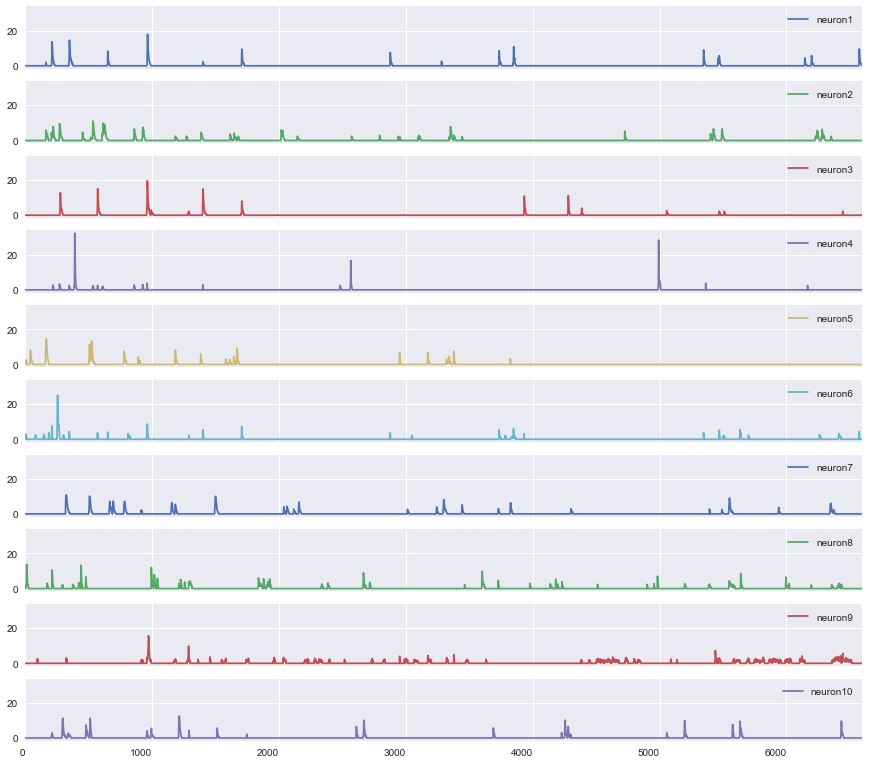

In [23]:
data = pd.read_csv('~/TraceRaw_Mouse_drd46.csv', header=None)

# returns [cell_data, cell_AUC_df, cell_transients]
lst_of_dataframes = Core.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

#lst_of_dataframes[1].plot(subplots=True, figsize=(20, 20));
#lst_of_dataframes[2].plot(subplots=True, figsize=(20, 20));

lst_of_dataframes[0].columns = ['neuron' + str(i) for i in range(1, len(lst_of_dataframes[2].columns)+1)]
lst_of_dataframes[1].columns = ['neuron' + str(i) for i in range(1, len(lst_of_dataframes[2].columns)+1)]
lst_of_dataframes[2].columns = ['neuron' + str(i) for i in range(1, len(lst_of_dataframes[2].columns)+1)]

z_scored_dataframe = lst_of_dataframes[0]
AUC_dataframe = lst_of_dataframes[1]
cell_transients_dataframe = lst_of_dataframes[2]

lst_of_dataframes[2].plot(subplots=True, figsize=(15, 15), sharex=True, sharey=True, rot=0);

In [19]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

activity_df = pd.read_csv('~/Hen_Lab/Mice/drd46_experiments/activity_drd46.csv', header=None)
behavior_df = pd.read_csv('~/Hen_Lab/Mice/drd46_experiments/behavior_drd46.csv', header=None)

# Save only every nth row in order to downsample behavior Dataframes from 30fps -> 10fps
ROW_MULTIPLE = 3
behavior_df.drop(behavior_df.index[[i for i in range(0, len(behavior_df.index)) if i % ROW_MULTIPLE != 0]], inplace=True)

# For the activity Dataframe, we Change column names to corresponding neuron names 
activity_df.columns = ['neuron' + str(i) for i in range(1, len(activity_df.columns) + 1)]

# Change column names to the behavior column names found in the MossyEPM, MATLAB struct
behavior_df.columns = behavior_column_names

# Fix indexing after downsample
behavior_df.reset_index(drop=True, inplace=True)

# Make the behavior Dataframe indexed by Recording time
# behavior_df.set_index('Recording time', inplace=True)

# Make the behavior Dataframe and the activity Dataframe have the same amount of rows 
if len(behavior_df.index) > len(activity_df.index):
    diff = len(behavior_df.index) - len(activity_df.index)
    behavior_df = behavior_df[:-diff]
elif len(behavior_df.index) < len(activity_df.index):
    diff = len(activity_df.index) - len(behavior_df.index)
    activity_df = activity_df[:-diff]

# Define running frames
VELOCITY_CUTOFF = 4;

# Adds column to the end of the behavior Dataframe and make each cell in that column a 0 
# if the corresponding velocity < VELOCITY_CUTOFF or a 1 if the corresponding velocity >= VELOCITY_CUTOFF
behavior_df['Running_frames'] = [1 if velocity > VELOCITY_CUTOFF else 0 for velocity in behavior_df['Velocity'].tolist()]

# Calculate rates by arm, running, and time period

# Divide session into this many bins
TIME_BIN_FACTOR = 3; 

# activity_df
# behavior_df
AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
result_dataframe = pd.concat([AUC_dataframe, behavior_df], axis=1)
# result_dataframe

In [11]:
print("*** BEGIN TEST ***")
print("Expected: 0.75027020368342978")
print("Actual: {}".format(activity_by_neurons(result_dataframe, 'neuron6', OpenArms_centerpoint=1)))
print("*** END TEST ***\n")

print(activity_by_neurons(result_dataframe, 'neuron1', OpenArms_centerpoint=1))
print(activity_by_neurons(result_dataframe, 'neuron1', ClosedArms_centerpoint=1))

print(activity_by_neurons(result_dataframe, 'neuron3', Running_frames=1))
print(activity_by_neurons(result_dataframe, 'neuron3', Running_frames=0))

print(activity_by_neurons(result_dataframe, 'neuron10', OpenArms_centerpoint=1, Running_frames=1))

*** BEGIN TEST ***
Expected: 0.75027020368342978
Actual: 0.7502702036834298
*** END TEST ***

1.22564093462
1.44139875911
1.3462558372
1.25864154511
0.319223776742


In [ ]:
# TODO: Fix this function so that it works with activity_by_neurons()
def load_Activities_DataFrame(dataframe):
    
    activities_dict = {}
    behaviors = ['Arena_centerpoint', 'Open1_centerpoint', 'Open2_centerpoint', 'Closed1_centerpoint', 
                 'Closed2_centerpoint', 'OpenArms_centerpoint', 'ClosedArms_centerpoint']

    activities_dataframe = pd.DataFrame(index=AUC_dataframe.columns)

    for behavior in behaviors:
        for neuron in AUC_dataframe:
            activities_dict[neuron] = (activity_by_neurons(dataframe, neuron, behavior))

        activities_dataframe[behavior] = pd.Series(activities_dict)

    return activities_dataframe

In [ ]:
experiment = load_Activities_DataFrame(result_dataframe)
experiment

In [ ]:
experiment.plot.bar(figsize=(17, 5), rot=0);

In [16]:
# result_dataframe.plot.scatter(x='Trial time', y='neuron7');

neuron7_list = list()
for i in range(0, result_dataframe['neuron7'].size):
    if result_dataframe['Open2_centerpoint)'][i] != 0:
        neuron7_list.append(result_dataframe['neuron7'][i])
    else:
        neuron7_list.append(np.nan)
        
# neuron7_dataframe = result_dataframe[['Trial time']].copy()
# neuron7_dataframe['neuron7'] = pd.Series(neuron7_list)
# neuron7_dataframe['neuron7'][neuron7_dataframe['neuron7'] > 0]
# neuron7_dataframe['neuron7'] = pd.DataFrame(columns=[n]neuron7_list)
# sns.regplot(x=result_dataframe['Trial time'], y=neuron7_dataframe['neuron7'], color="g");

KeyError: 'Open2_centerpoint)'

[1.412456799398948, 1.5293914350112698, 1.3462359128474832, 0.49829075882794893, 1.7421111945905334, 0.41998009015777615, 2.080439519158528, 3.1823384673178063, 3.5059083395942903, 2.7415135236664163]
[1.6788034535297103, 3.226457592686643, 1.2586244286439816, 1.055068308786186, 1.5058471305231087, 1.7695911630269172, 2.3405992889791776, 1.7558778567800915, 2.630134586084307, 1.261440832910107]


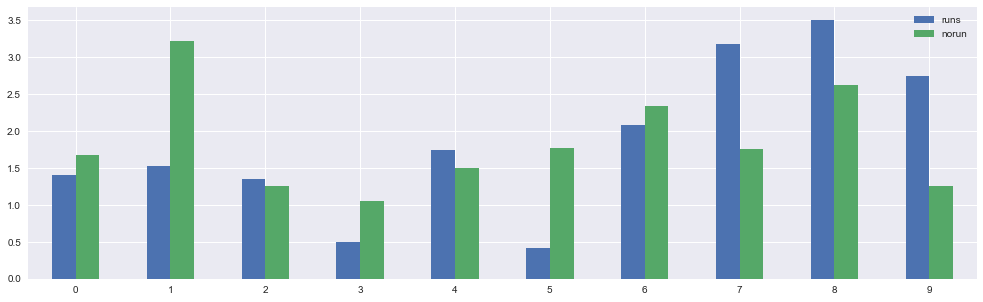

In [12]:
FRAME_RATE = 10
run_vector = behavior_df['Running_frames'][behavior_df['Running_frames'] != 0].index.tolist()
no_run_vector = behavior_df['Running_frames'][behavior_df['Running_frames'] == 0].index.tolist()

run_sums = [activity_df[column][run_vector].sum() for column in activity_df]
no_run_sums = [activity_df[column][no_run_vector].sum() for column in activity_df]   

run_sums1 = [FRAME_RATE * run_sums[i] / len(run_vector) for i in range(0, len(run_sums))]
no_run_sums1 = [FRAME_RATE * no_run_sums[i] / len(no_run_vector) for i in range(0, len(no_run_sums))]
print(run_sums1)
print(no_run_sums1)
run_noruns_dataframe = pd.DataFrame(columns=['runs', 'norun'])
run_noruns_dataframe['runs'] = pd.Series(run_sums1)
run_noruns_dataframe['norun'] = pd.Series(no_run_sums1)
run_noruns_dataframe.plot.bar(figsize=(17, 5), rot=0);

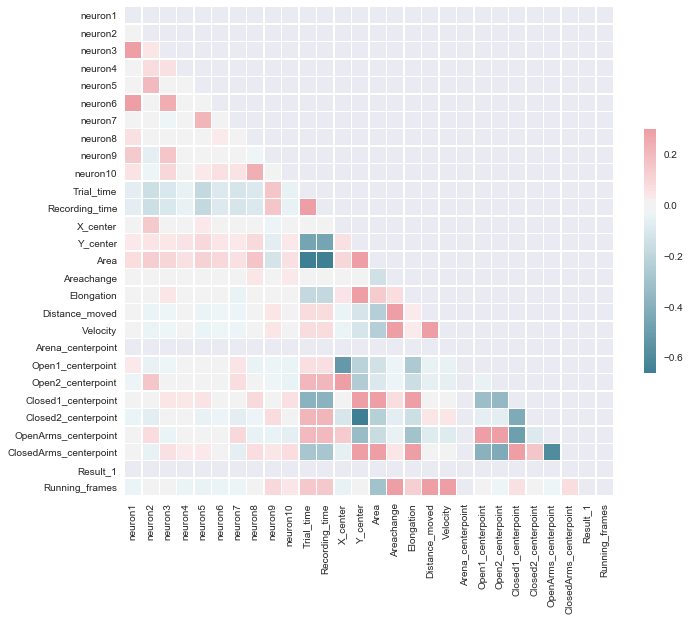

In [13]:
# Compute the correlation matrix
corr = pd.concat([cell_transients_dataframe, behavior_df], axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

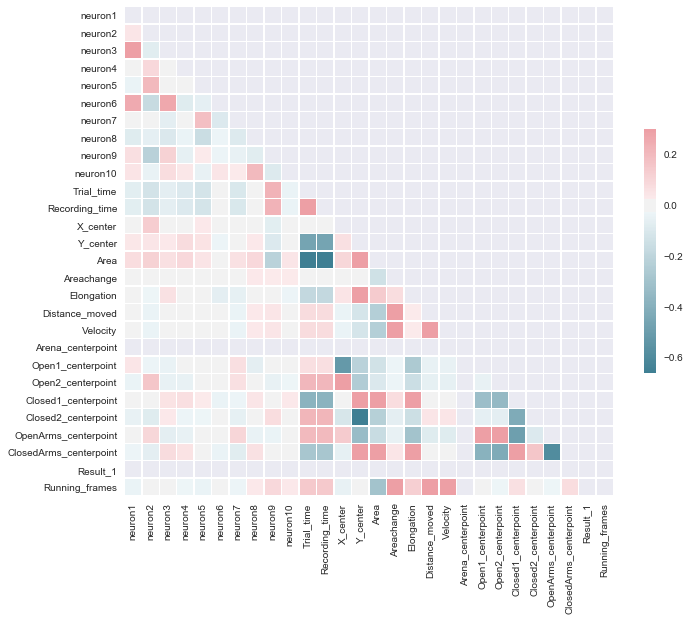

In [14]:
# Compute the correlation matrix
corr = pd.concat([z_scored_dataframe, behavior_df], axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});